In [ ]:
%pip install pandas seaborn matplotlib scikit-learn gensim eli5 tiktoken spacy


In [1]:
import sys
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from nltk import word_tokenize          
import pandas as pd
import math

sys.path.append('../utils/')
from tokenize_api import gpt_tokenize,preprocess_text

sys.path.append('..')
from preprocessing import load_preprocessed_dataframe, load_dataframes
from constants import CATEGORIES
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop
from utils.gpt_tokenize import normalize2_text
import tiktoken


In [2]:
output_dir = 'data'
df_train, df_val, df_test = load_preprocessed_dataframe(output_dir=output_dir)

5 sec TO LOAD


In [3]:
df_train.head()


,id,comment_text_baseline,toxic,severe_toxic,obscene,threat,insult,identity_hate,overall_toxic,comment_text_bpe_tokenize_full_normalization,comment_text_word_tokenize_no_normalization,comment_text_gpt_tokenize_no_normalization,comment_text_word_tokenize_normalization,comment_text_gpt_tokenize_normalization,comment_text_word_tokenize_full_normalization,comment_text_gpt_tokenize_full_normalization,comment_text_word_tokenize_simple_normalization,comment_text_gpt_tokenize_simple_normalization,comment_text_bpe_tokenize_simple_dup_normalization,comment_text_bpe_tokenize_no_dup_no_punc_normalization
140030,ed56f082116dcbd0,Grandma Terri Should Burn in Trash \nGrandma T...,1,0,0,0,0,0,1,grandma ter ri burn trash grandma ter ri trash...,Grandma Terri Should Burn in Trash Grandma Ter...,41251 1764 10335 462 12540 18530 304 71723 720...,grandma terri burn trash grandma terri trash ....,53766 1764 2024 462 8395 23701 83777 2024 462 ...,grandma terri burn trash grandma terri trash h...,53766 1764 2024 462 8395 23701 83777 2024 462 ...,grandma terri should burn in trash grandma ter...,53766 1764 2024 462 1288 8395 304 23701 83777 ...,grandma ter ri should burn in trash grandma te...,grandma ter ri should burn in trash grandma te...
159124,f8e3cd98b63bf401,", 9 May 2009 (UTC)\nIt would be easiest if you...",0,0,0,0,0,0,0,may ut c would easy admit member involved port...,", 9 May 2009 ( UTC ) It would be easiest if yo...",11 220 24 3297 220 1049 24 320 21872 340 2181 ...,", may ( utc ) would easy admit member involved...",11 1253 320 70696 883 1053 4228 17113 4562 653...,may utc would easy admit member involved portu...,18864 70696 1053 4228 17113 4562 6532 2700 773...,", may ( utc ) it would be easiest if you were ...",11 1253 320 29455 8 433 1053 387 30689 422 499...,", may ( ut c ) it would be easiest if you were...",may ut c it would be easiest if you were to ad...
60006,a09e1bcf10631f9a,"""\n\nThe Objectivity of this Discussion is dou...",0,0,0,0,0,0,0,objectivity discussion doubtful non existent i...,`` The Objectivity of this Discussion is doubt...,1875 791 3075 1968 315 420 36613 374 75699 320...,`` objectivity discussion doubtful ( non-exist...,14196 1665 1968 10430 75699 320 2536 60928 883...,objectivity discussion doubtful non existent i...,1735 1968 10430 75699 2536 3073 306 13519 6931...,`` the objectivity of this discussion is doubt...,1 279 1665 1968 315 420 10430 374 75699 320 64...,""" the objectivity of this discussion is doubtf...",the objectivity of this discussion is doubtful...
65432,af0ee0066c607eb8,Shelly Shock\nShelly Shock is. . .( ),0,0,0,0,0,0,0,shel ly shock shel ly shock,Shelly Shock Shelly Shock is . . . ( ),2059 12160 48083 198 2059 12160 48083 374 13 6...,shelly shock shelly shock . . . ( ),939 12160 10988 559 12160 10988 662 662 662 32...,shelly shock shelly shock,939 12160 10988 559 12160 10988,shelly shock shelly shock is . . . ( ),939 12160 10988 559 12160 10988 374 13 662 662...,shel ly shock shel ly shock is . . .( ),shel ly shock shel ly shock is
154979,b734772b1a807e09,I do not care. Refer to Ong Teng Cheong talk p...,0,0,0,0,0,0,0,care refer ong ten g che ong talk page la gout...,I do not care . Refer to Ong Teng Cheong talk ...,40 656 539 2512 13 29734 311 507 983 350 833 8...,care . refer ong teng cheong talk page . la go...,10727 662 8464 389 70 42249 3091 647 3137 2199...,care refer ong teng cheong talk page la goutte...,10727 8464 389 70 42249 3091 647 3137 2199 120...,i do not care . refer to ong teng cheong talk ...,72 656 539 2512 13 8464 311 389 70 42249 3091 ...,i do not care . refer to ong ten g che ong tal...,i do not care refer to ong ten g che ong talk ...


In [6]:
# Séparation du DataFrame en deux sous-ensembles selon la valeur de la colonne "overall_toxic"
df_toxic = df_train[df_train['overall_toxic'] == 1]
df_non_toxic = df_train[df_train['overall_toxic'] == 0]

# Détermination du nombre minimum de lignes dans chaque classe
min_samples = min(len(df_toxic), len(df_non_toxic))

# Échantillonnage d'un nombre égal de lignes dans chaque classe
df_toxic_sampled = df_toxic.sample(n=min_samples, replace=True, random_state=42)
df_non_toxic_sampled = df_non_toxic.sample(n=min_samples, replace=True, random_state=42)

# Concaténation des deux sous-ensembles échantillonnés
df_balanced = pd.concat([df_toxic_sampled, df_non_toxic_sampled], ignore_index=True)

# Mélange des lignes pour mélanger les classes
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_train = df_balanced
# Affichage des informations sur le nouveau DataFrame équilibré
print("Nombre de lignes avec overall_toxic=1 :", len(df_train[df_train['overall_toxic'] == 1]))
print("Nombre de lignes avec overall_toxic=0 :", len(df_train[df_train['overall_toxic'] == 0]))


Nombre de lignes avec overall_toxic=1 : 12981
Nombre de lignes avec overall_toxic=0 : 12981


In [8]:
#  tokens = gpt_tokenize(df_train)


In [4]:
#print(tokens[:100])


[53766, 1764, 2024, 462, 8395, 23701, 83777, 2024, 462, 23701, 662, 12491, 83777, 2024, 462, 662, 282, 1034, 1034, 597, 15123, 758, 220, 6028, 13, 5728, 13, 4767, 13, 1272, 1174, 220, 24, 1253, 220, 1049, 24, 320, 70696, 883, 1053, 30689, 17113, 4562, 6532, 2700, 773, 36554, 60891, 1174, 1053, 16686, 25670, 3508, 3766, 2759, 320, 1841, 2353, 11164, 87099, 1695, 3335, 883, 1053, 4148, 11334, 79, 39936, 3896, 40815, 662, 12895, 551, 1080, 72, 11810, 1274, 4600, 4652, 1174, 10030, 73, 5472, 1174, 3152, 16994, 23391, 5905, 1203, 51944, 2660, 869, 62411, 662, 220, 508, 25, 1682, 10103]


In [11]:
#enc = tiktoken.encoding_for_model("gpt-4")
#tokens_list = [(enc.decode([word])) for word in tokens]



In [9]:
#print(tokens_list[:100])
#enc.decode([53766])


['grand', 'ma', ' ter', 'ri', ' burn', ' trash', ' grandma', ' ter', 'ri', ' trash', ' .', ' hate', ' grandma', ' ter', 'ri', ' .', ' f', ' %', ' %', ' k', ' hell', ' !', ' ', '71', '.', '74', '.', '76', '.', '40', ' ,', ' ', '9', ' may', ' ', '200', '9', ' (', ' utc', ' )', ' would', ' easiest', ' admit', ' member', ' involved', ' port', 'ug', 'uese', ' lodge', ' ,', ' would', ' requirement', ' acknowledge', ' whether', ' previous', ' account', ' (', ' car', 'los', ' bot', 'elho', ' good', ' record', ' )', ' would', ' remove', ' sock', 'p', 'uppet', ' template', ' irrelevant', ' .', ' wp', ' :', ' co', 'i', ' permit', ' people', ' edit', ' article', ' ,', ' ms', 'j', 'apan', ' ,', ' mean', ' careful', ' ensuring', ' reference', ' back', ' edits', ' np', 'ov', ' upheld', ' .', ' ', '20', ':', '29', ' ``']


'grand'

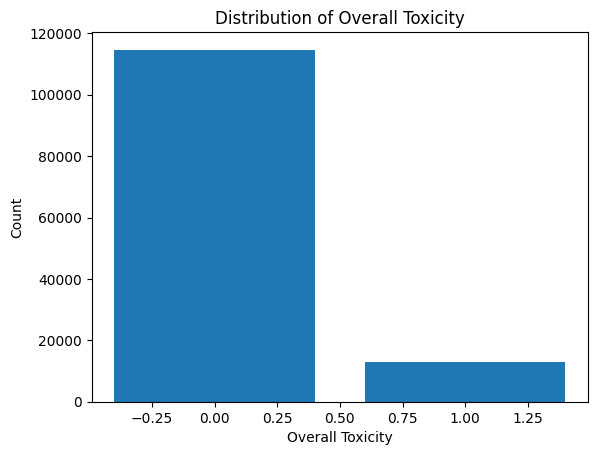

In [4]:
train_df = df_train
total_user_input = len(train_df)
toxicity_1 = len(train_df[train_df['overall_toxic'] == 1])
toxicity_0 = len(train_df[train_df['overall_toxic'] == 0])

table = pd.DataFrame({'Total User Input': [total_user_input], 'Toxicity 1': [toxicity_1], 'Toxicity 0': [toxicity_0]})
table

# Count the number of occurrences of each category
toxic_counts = train_df['overall_toxic'].value_counts()

# Create a bar plot
plt.bar(toxic_counts.index, toxic_counts.values)

# Add labels and title
plt.xlabel('Overall Toxicity')
plt.ylabel('Count')
plt.title('Distribution of Overall Toxicity')

# Show the plot
plt.show()



In [5]:
df_train.describe()


,toxic,severe_toxic,obscene,threat,insult,identity_hate,overall_toxic
count,127656.000000,127656.00000,127656.000000,127656.000000,127656.000000,127656.000000,127656.000000
mean,0.095867,0.00998,0.052751,0.003165,0.049062,0.008703,0.101687
std,0.294410,0.09940,0.223537,0.056167,0.215997,0.092884,0.302238
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
params ={ 
    "word_tokenize_no_normalization":
    {
        "tokenize": word_tokenize,
        "is_lemmatization": False,
        "remove_stopwords": False,
        "is_replace_emojis": False,
        "is_lowercase": False,
        "remove_stopwords": False,
        "is_lemmatization": False,
    },
    "gpt_tokenize_no_normalization":
    {
        "tokenize": gpt_tokenize,
        "is_lemmatization": False,
        "remove_stopwords": False,
        "is_replace_emojis": False,
        "is_lowercase": False,
        "remove_stopwords": False,
        "is_lemmatization": False,
    },
    "word_tokenize_normalization":
    {
        "tokenize": word_tokenize,
        "is_lemmatization": True,
        "remove_stopwords": True,
        "is_replace_emojis": True,
        "is_lowercase": True,
        "remove_stopwords": True,
        "is_lemmatization": True,
    },
    "gpt_tokenize_normalization":
    {
        "tokenize": gpt_tokenize,
        "is_lemmatization": True,
        "remove_stopwords": True,
        "is_replace_emojis": True,
        "is_lowercase": True,
        "remove_stopwords": True,
        "is_lemmatization": True,
    },
}


In [7]:
for tn, p in params.items():
    df_train[f'comment_text_{tn}'] = df_train['comment_text'].apply(lambda x: preprocess_text(x, **p))
    df_test[f'comment_text_{tn}'] = df_test['comment_text'].apply(lambda x: preprocess_text(x, **p))
import os
if not os.path.exists('data'):
    os.makedirs('data')
df_train.to_parquet('data/df_train_preprocessed.parquet')
df_test.to_parquet('data/df_test_preprocessed.parquet')


OSError: Cannot save file into a non-existent directory: 'data'

In [9]:
df_train


,id,comment_text_baseline,toxic,severe_toxic,obscene,threat,insult,identity_hate,overall_toxic,comment_text_word_tokenize_no_normalization,comment_text_gpt_tokenize_no_normalization,comment_text_word_tokenize_normalization,comment_text_gpt_tokenize_normalization,comment_text_word_tokenize_full_normalization,comment_text_gpt_tokenize_full_normalization,comment_text_word_tokenize_simple_normalization,comment_text_gpt_tokenize_simple_normalization
0,3fbfcd7d833bdf09,"""\nWell, I used to avoid it, but I seem to be ...",0,0,0,0,0,0,0,"`` Well , I used to avoid it , but I seem to b...",""" Well, I used to avoid it, but I seem to be i...","`` well , use avoid , seem irresistably draw t...",""" well, use avoid it, seem irresistably draw t...",well use avoid seem irresistably draw try reso...,well use avoid seem irresistably draw try reso...,"`` well , used avoid , seem irresistably drawn...",""" well, used avoid it, seem irresistably drawn..."
1,6f0dd694ce97003b,Ordinary but slightly stupider than ordinary p...,1,0,0,0,1,0,1,Ordinary but slightly stupider than ordinary p...,Ordinary but slightly stupider than ordinary p...,ordinary slightly stupid ordinary people ) hen...,ordinary slightly stupid ordinary people ) hen...,ordinary slightly stupid ordinary people hence...,ordinary slightly stupid ordinary people hence...,ordinary slightly stupider ordinary people ) h...,ordinary slightly stupider ordinary people ) h...
2,288e2252ca460724,"Well my apologies, I guess I didn't read all t...",1,0,1,0,1,0,1,"Well my apologies , I guess I did n't read all...","Well my apologies, I guess I didn't read all t...","well apology , guess n't read rule carefully f...","well apologies, guess read rule carefully fuck...",well apology guess didnt read rule carefully f...,well apology guess didnt read rule carefully f...,"well apologies , guess n't read rules wikipedi...","well apologies, guess read rules wikipedia car..."
3,6ed9130d909a1421,PS: Cannucks suck balls. I believe they are be...,1,0,1,0,1,0,1,PS : Cannucks suck balls . I believe they are ...,PS: Cannucks suck balls. I believe they are be...,ps : cannucks suck ball . believe well know ca...,ps: cannucks suck balls. believe well know can...,ps cannucks suck ball believe well know cansuc...,ps cannucks suck ball believe well know cansuc...,ps : cannucks suck balls . believe better know...,ps: cannucks suck balls. believe better known ...
4,bf3257814e8a345a,Bulgarian helmet of World War II,0,0,0,0,0,0,0,Bulgarian helmet of World War II,Bulgarian helmet of World War II,bulgarian helmet world war ii,bulgarian helmet world war ii,bulgarian helmet world war ii,bulgarian helmet world war ii,bulgarian helmet world war ii,bulgarian helmet world war ii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25957,a3a57f5bc137d696,"Unprotected\nOk, I've unprotected the article....",0,0,0,0,0,0,0,"Unprotected Ok , I 've unprotected the article...","Unprotected Ok, I've unprotected the article. ...","unprotected ok , unprotected article . rfc , a...","unprotected ok, i've unprotected article. rfc,...",unprotected ok ive unprotected article rfc app...,unprotected ok ive unprotected article rfc app...,"unprotected ok , unprotected article . rfc , a...","unprotected ok, i've unprotected article. rfc,..."
25958,e435dd69638489f9,Me ban \n\nI shouldn't have been banned. That ...,1,0,0,0,0,0,1,Me ban I should n't have been banned . That wa...,Me ban I shouldn't have been banned. That was ...,ban n't ban . complete abuse utter bullshit . ...,ban banned. complete abuse utter bullshit. hop...,ban shouldnt ban complete abuse utter bullshit...,ban shouldnt ban complete abuse utter bullshit...,ban n't banned . complete abuse utter bullshit...,ban banned. complete abuse utter bullshit. hop...
25959,12703d55c77ed5b1,SHUT THE FUCK UP!\nSHUT THE FUCK UP!\nSHUT THE...,1,1,1,0,1,0,1,SHUT THE FUCK UP ! SHUT THE FUCK UP ! SHUT THE...,SHUT THE FUCK UP! SHUT THE FUCK UP! SHUT THE F...,shut fuck ! shut fuck ! shut

In [10]:
X = df_train['comment_text_gpt_tokenize_normalization']
y = df_train['overall_toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#sample_weights = compute_sample_weight(class_weight='balanced', y=y_train) #ne semble pas necessaire car il y a qu'une seul classe possible
#model = make_pipeline(CountVectorizer(ngram_range = (1,1)), MultinomialNB())
# Etape 1 : Calcul de la fréquence des mots
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
# Etape 2 : Sélection des stop words
word_freq = X_train_counts.sum(axis=0)  # Somme des fréquences pour chaque terme
words = vectorizer.get_feature_names_out()
freqs = zip(words, word_freq.A1)  # A1 convertit une matrice 1D en array numpy
sorted_words = sorted(freqs, key=lambda x: x[1], reverse=True)

n_stop_words = 0  # ou 10, selon votre choix
stop_words = [word for word, freq in sorted_words[:n_stop_words]]

# Etape 3 : Filtrage des stop words et entraînement du modèle
vectorizer_with_stop_words_filter = CountVectorizer(stop_words=stop_words)
model = make_pipeline(vectorizer_with_stop_words_filter, MultinomialNB())
X_train_counts = vectorizer.fit_transform(X_train)
#model = make_pipeline(   CountVectorizer(tokenizer=normalize2_text, ngram_range=(1,1),stop_words=list(en_stop)),MultinomialNB())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [11]:
X_train


8124     awful, awful!!! germans murderers blood millio...
1535                              anal leakage ban hammer?
2878     fuck you, cunt. ever fuck accuse vandalism. ev...
5140     hey sue, u. u know hey sue anne, you? hope fin...
20005       first-class dick. focus edit article properly.
                               ...                        
21575    masturbate custard? hear poplular white people...
5390                  propose sir, unconscienable dickwad.
860                       email note email sent. '''' (ho)
15795    dare yank english language state sulphur, elem...
23654    there! get little (very little) info basic kir...
Name: comment_text_gpt_tokenize_normalization, Length: 20769, dtype: object

In [12]:
#print(vectorizer.vocabulary_)
#len(vectorizer.vocabulary_)
print(stop_words)
#print(vectorizer_with_stop_words_filter.vocabulary_["and"])``
#print(vectorizer.vocabulary_["656"])
# lignes_contenant_naruto = X_train[1246]
# lignes_contenant_naruto



[]


In [13]:
print(f"Features dimension: {len(X_train), len(model[0].vocabulary_)}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Features dimension: (20769, 41238)
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      2575
           1       0.90      0.87      0.89      2618

    accuracy                           0.89      5193
   macro avg       0.89      0.89      0.89      5193
weighted avg       0.89      0.89      0.89      5193



### Comparaison de toute les types de normalisation ou tokenisation

In [6]:
columns = [
    'comment_text_baseline',
    'comment_text_bpe_tokenize_full_normalization',
    'comment_text_word_tokenize_no_normalization',
    'comment_text_gpt_tokenize_no_normalization',
    'comment_text_word_tokenize_normalization',
    'comment_text_gpt_tokenize_normalization',
    'comment_text_word_tokenize_full_normalization',
    'comment_text_gpt_tokenize_full_normalization',
    'comment_text_word_tokenize_simple_normalization',
    'comment_text_gpt_tokenize_simple_normalization',
    'comment_text_bpe_tokenize_simple_dup_normalization',
    'comment_text_bpe_tokenize_no_dup_no_punc_normalization'
]


for col in columns:
    print(f"\n\n{'='*20} {col} {'='*20}\n")
    X = df_train[col]
    y = df_train['overall_toxic']
    y_test = df_test['overall_toxic']
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    vectorizer = CountVectorizer()
    X_train_counts = vectorizer.fit_transform(X)

    word_freq = X_train_counts.sum(axis=0)
    words = vectorizer.get_feature_names_out()
    freqs = zip(words, word_freq.A1)
    sorted_words = sorted(freqs, key=lambda x: x[1], reverse=True)

    n_stop_words = 0  # ou 10, selon votre choix
    stop_words = [word for word, freq in sorted_words[:n_stop_words]]

    vectorizer_with_stop_words_filter = CountVectorizer(stop_words=stop_words)
    model = make_pipeline(vectorizer_with_stop_words_filter, MultinomialNB())
    X_train_counts = vectorizer.fit_transform(X)
    model.fit(X, y)
    y_pred = model.predict(df_test[col])

    print(f"Features dimension: {len(X), len(model[0].vocabulary_)}")
    print("Classification Report:\n", classification_report(y_test, y_pred))



==================== comment_text_baseline ====================

Features dimension: (127656, 165785)
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     57735
           1       0.54      0.68      0.60      6243

    accuracy                           0.91     63978
   macro avg       0.75      0.81      0.78     63978
weighted avg       0.92      0.91      0.92     63978



==================== comment_text_bpe_tokenize_full_normalization ====================

Features dimension: (127656, 29611)
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     57735
           1       0.53      0.77      0.63      6243

    accuracy                           0.91     63978
   macro avg       0.75      0.85      0.79     63978
weighted avg       0.93      0.91      0.92     63978



==================== comment_text_word_tokenize_no_normalization =

## Plot confusion matrix

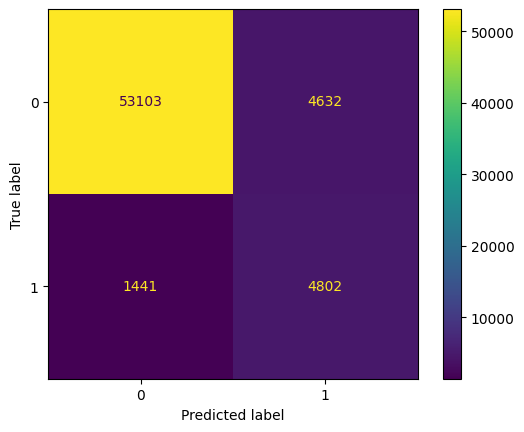

In [7]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()


## Cross validation



In [8]:
# Perform cross-validation and print the mean accuracy
scoring = 'f1_macro'
scores = cross_val_score(model, X, y, cv=5, scoring=scoring, n_jobs = -1)
print(f"Mean {scoring}: {scores.mean()}")
print(f"Standard deviation {scoring}: {scores.std()}")


Mean f1_macro: 0.843866364320095
Standard deviation f1_macro: 0.005564170550786779


In [17]:
#y_train.head()

#X_train.head()


51730     .  And that would verify that John was a Pratt...
104007    hi how are you  are you Mr bill \n\naoa \n    ...
93525                            Abi 17:45, 9 February 2014
157886    We can agree on one thing: the numbers do spea...
153252    I noticed that on the media page there are onl...
Name: comment_text, dtype: object

### Calculate priors and vocabulary

In [11]:
count_c = Counter(y)

priors = {k:v/len(y) for k, v in count_c.items()}
print(priors)
words = list(vectorizer_with_stop_words_filter.vocabulary_.keys())
train_strings = " ".join(words)
train_tokens = word_tokenize(train_strings)
vocabulary = set(train_tokens)
V = len(vocabulary)
classes = set(y)


{1: 0.10168734724572288, 0: 0.8983126527542771}


In [12]:
print(vocabulary)
len(vocabulary)


{'ferences', 'laki', 'pleasure', 'izers', 'overwritten', 'lain', 'taker', 'reply', 'nucleus', 'featured', 'heroic', 'precious', 'azan', 'achieved', 'isai', 'focusing', 'disscus', 'habitable', 'zar', 'mw', 'ciliatory', 'volunteering', 'bits', 'targetted', 'antide', 'objectively', 'rier', 'tado', 'configurations', 'grape', 'enlisted', 'clerical', 'inspection', 'ids', 'ceptions', 'attacked', 'apologising', 'consistencies', 'contributions', 'idimensional', 'rl', 'heres', 'wrongly', 'positivism', 'passe', 'psychiatric', 'spouses', 'tuff', 'briefings', 'metadata', 'tos', 'fection', 'pasting', 'bourgeois', 'immolation', 'fortnight', 'quip', 'corrupt', 'uin', 'nese', 'osis', 'cult', 'deems', 'low', 'booted', 'agendas', 'aneous', 'amends', 'colder', 'iose', 'sar', 'independant', 'wikepedia', 'inaccuracy', 'alludes', 'occurred', 'astrolog', 'm_', 'worried', 'modo', 'simon', 'takes', 'hor', 'scores', 'measures', 'majestic', 'trustworthy', 'pheus', 'initials', 'delt', 'ropes', 'transformer', 'shgi

33397

In [13]:
print(classes)


{0, 1}


### Calculate likelihoods


In [15]:
train_df = pd.DataFrame(zip(X, y), columns = ["comment_text_bpe_tokenize_full_normalization", "overall_toxic"])
train_df = pd.DataFrame(train_df)
train_df


,comment_text_bpe_tokenize_full_normalization,overall_toxic
0,grandma ter ri should burn in trash grandma te...,1
1,may ut c it would be easiest if you were to ad...,0
2,the objectivity of this discussion is doubtful...,0
3,shel ly shock shel ly shock is,0
4,i do not care refer to ong ten g che ong talk ...,0
...,...,...
127651,redirect talk john loved ay experimental physi...,0
127652,back it up post the line here with the reference,0
127653,i wont stop that sometimes germanic equals ger...,1
127654,british bands i think youve mistaken scottish ...,0


In [16]:
mega_dict = dict() 
prob_dict = dict()
k = 1

for c in classes:
    class_df = df_train[df_train["overall_toxic"] == c]
    mega_document = class_df["comment_text_gpt_tokenize_normalization"]
    mega_strings = " ".join(mega_document)
    mega_tokens = word_tokenize(mega_strings)
    mega_count = Counter(mega_tokens)
    mega_dict[c] = mega_count
    prob_dict[c] = dict()
    for token in vocabulary:
        prob_dict[c][token] = (mega_dict[c][token] + k ) / (len(mega_tokens) + V)


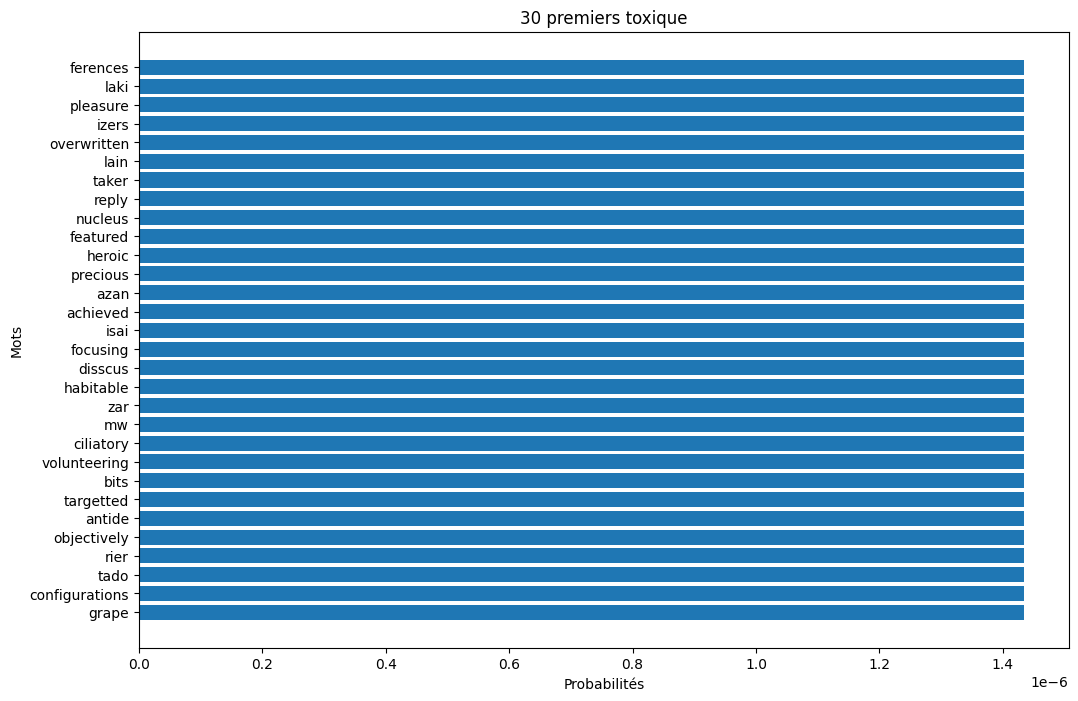

In [17]:
import matplotlib.pyplot as plt

# Trier les éléments du dictionnaire par valeur décroissante et sélectionner les 30 premiers
top_tokens = sorted(prob_dict[1].items(), key=lambda x: x[1], reverse=True)[:30]

# Extraire les mots et les valeurs associées
tokens = [token for token, _ in top_tokens]
probs = [prob for _, prob in top_tokens]

# Créer le graphique à barres horizontales
plt.figure(figsize=(12, 8))  # Vous pouvez ajuster la taille pour mieux ajuster les étiquettes si nécessaire
plt.barh(tokens, probs)
plt.xlabel('Probabilités')
plt.ylabel('Mots')
plt.title('30 premiers toxique')
plt.gca().invert_yaxis()  # Inverser l'axe des y pour que les valeurs les plus élevées apparaissent en haut
plt.show()


In [18]:
print(mega_dict[1]["patrick"]) # ici on verifie le nombre de fois où "eithan" est présent dans les phrases non toxic (0)
print(prob_dict[0]["like"]) # ici on verifie la prob par rapport au token et a la toxicité cf cours formule


0
1.551038311576919e-07


### Prediction

In [20]:
test_tokens = word_tokenize("thats for my niggers")
test_tokens = [token for token in test_tokens if token in vocabulary]
print(test_tokens)
pred_dict = dict()

for c in classes:
    sum = math.log2(priors[c])
    for token in test_tokens:
        #print(prob_dict[c][token])
        sum += math.log2(prob_dict[c][token])
    sum = math.pow(2, sum)
    pred_dict[c] = sum
print(pred_dict)
print(max(pred_dict, key=pred_dict.get))


['thats', 'for', 'my', 'niggers']
{0: 5.198973669062574e-28, 1: 4.312926171895481e-25}
1


In [21]:
test_tokens = [word_tokenize(text) for text in X_test]

pred_dict = dict()
preds = list()

for report_tokens in test_tokens:
    for c in classes:
        suma = math.log2(priors[c])
        for token in report_tokens:
            if token in prob_dict[c]: # remove unknown tokens
                suma += math.log2(prob_dict[c][token])
        suma = math.pow(2, suma)
        pred_dict[c] = suma
    preds.append(max(pred_dict, key=pred_dict.get))


NameError: name 'X_test' is not defined

In [29]:
print(classification_report(preds, list(y_test)))


              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2735
           1       0.86      0.92      0.89      2458

    accuracy                           0.89      5193
   macro avg       0.89      0.89      0.89      5193
weighted avg       0.89      0.89      0.89      5193



In [47]:
def train_model():
    (df_train, df_val, df_test) = load_preprocessed_dataframe()
    X = df_train['comment_text_baseline']
    y = df_train['overall_toxic']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    vectorizer = CountVectorizer()
    X_train_counts = vectorizer.fit_transform(X_train)
    # Etape 2 : Sélection des stop words
    word_freq = X_train_counts.sum(axis=0)  # Somme des fréquences pour chaque terme
    words = vectorizer.get_feature_names_out()
    freqs = zip(words, word_freq.A1)  # A1 convertit une matrice 1D en array numpy
    sorted_words = sorted(freqs, key=lambda x: x[1], reverse=True)

    n_stop_words = 10  # ou 10, selon votre choix
    stop_words = [word for word, freq in sorted_words[:n_stop_words]]

    # Etape 3 : Filtrage des stop words et entraînement du modèle
    # SI ON VEUT NORMALIZER LES TEXTES
    #vectorizer_with_stop_words_filter = CountVectorizer(stop_words=stop_words,tokenizer=normalize2_text)
    vectorizer_with_stop_words_filter = CountVectorizer(stop_words=stop_words)
    model = make_pipeline(vectorizer_with_stop_words_filter, MultinomialNB())
    X_train_counts = vectorizer.fit_transform(X_train)
    #model = make_pipeline(   CountVectorizer(tokenizer=normalize2_text, ngram_range=(1,1),stop_words=list(en_stop)),MultinomialNB())
    model.fit(X_train, y_train)

    #Priors
    count_c = Counter(y_train)
    #priors = {k:v/len(y_train) for k, v in count_c.items()}
    words = list(vectorizer_with_stop_words_filter.vocabulary_.keys())
    train_strings = " ".join(words)
    train_tokens = word_tokenize(train_strings)
    vocabulary = set(train_tokens)
    classes = set(y_train)

    #LikeLihoods
    mega_dict = dict()
    prob_dict = dict()
    k = 1

    for c in classes:
        class_df = df_train[df_train["overall_toxic"] == c]
        mega_document = class_df["comment_text_baseline"]
        mega_strings = " ".join(mega_document)
        mega_tokens = word_tokenize(mega_strings)
        mega_count = Counter(mega_tokens)
        mega_dict[c] = mega_count
        prob_dict[c] = dict()
        for token in vocabulary:
            prob_dict[c][token] = (mega_dict[c][token] + k ) / (len(mega_tokens) + V)
    


In [48]:
def isToxicity(test_tokens):
    #test_tokens = normalize2_text(test_tokens)
    test_tokens = word_tokenize(test_tokens)
    test_tokens = [token for token in test_tokens if token in vocabulary]

    pred_dict = dict()

    for c in classes:
        sum = math.log2(priors[c])
        for token in test_tokens:
            #print(prob_dict[c][token])
            sum += math.log2(prob_dict[c][token])
        sum = math.pow(2, sum)
        pred_dict[c] = sum
    print(pred_dict)
    print(max(pred_dict, key=pred_dict.get))
    


In [49]:
train_model()


5 sec TO LOAD


In [22]:
isToxicity("fuck your mom")


NameError: name 'isToxicity' is not defined

### EITHAN

In [59]:


vectorizer = CountVectorizer()


X_train = vectorizer.fit_transform(df_train['user_input']).toarray()
X_valid = vectorizer.transform(df_val['user_input']).toarray()
X_test = vectorizer.transform(df_test['user_input']).toarray()

y_train = df_train['toxicity']
y_valid = df_val['toxicity']
y_test = df_test['toxicity']


In [15]:
train_model()


2922    0
2354    0
977     1
4129    0
3404    0
       ..
1514    0
3475    0
517     0
2505    0
2619    0
Name: toxicity, Length: 1017, dtype: int64


#### Model Binary Classification

In [10]:
model_binary_label = GaussianNB()
model_binary_label.fit(X_train, y_train)
model_binary_label.score(X_valid, y_valid)


0.7856440511307768

In [11]:
model_binary_label.score(X_test, y_test)


0.7672634271099744

#### Model Multilabel Classification 